In [ ]:
https://github.com/DirkEngfer/PandasTests
Monthly precipitation [mm] summed up in (Schleswig-Holstein/Germany). programmer: Dirk Engfer, Germany
Provided Input data file: wetter_historical_Schleswig.csv

------------------------------
Original source of Input Data:
------------------------------

Datenquelle:
https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivtagmonat.html?nn=510076
    
Deutscher Wetterdienst
Zentraler Vertrieb Klima und Umwelt
Frankfurter Straße 135
Postfach 100465
63004 Offenbach

Copyright notice by data provider:
https://www.dwd.de/DE/service/copyright/copyright_node.html


In [2]:
import os, numpy as np
import pandas as pd
homedir = os.getenv('HOME')

datapath = os.path.join(homedir, 'Dokumente','python-apps','tensorflow', 'eu_air_pollution_data')
datafile = 'wetter_historical_Schleswig.csv'

indatapath = os.path.join(datapath,datafile)

     MESS_DATUM_BEGINN  rain_x   start_dt  year  months_with_measures  year_  \
0             19601201   103.6 1960-12-01  1960                    12   1960   
1             19601101   137.8 1960-11-01  1960                    12   1960   
2             19601001    77.6 1960-10-01  1960                    12   1960   
3             19600901   121.2 1960-09-01  1960                    12   1960   
4             19600801   155.6 1960-08-01  1960                    12   1960   
..                 ...     ...        ...   ...                   ...    ...   
643           20180201    48.2 2018-02-01  2018                    12   2018   
644           20180101   134.0 2018-01-01  2018                    12   2018   
645           20181101    29.5 2018-11-01  2018                    12   2018   
646           20180501    43.9 2018-05-01  2018                    12   2018   
647           20181201    96.8 2018-12-01  2018                    12   2018   

     yearly_mean  rain_sum  
0     903.

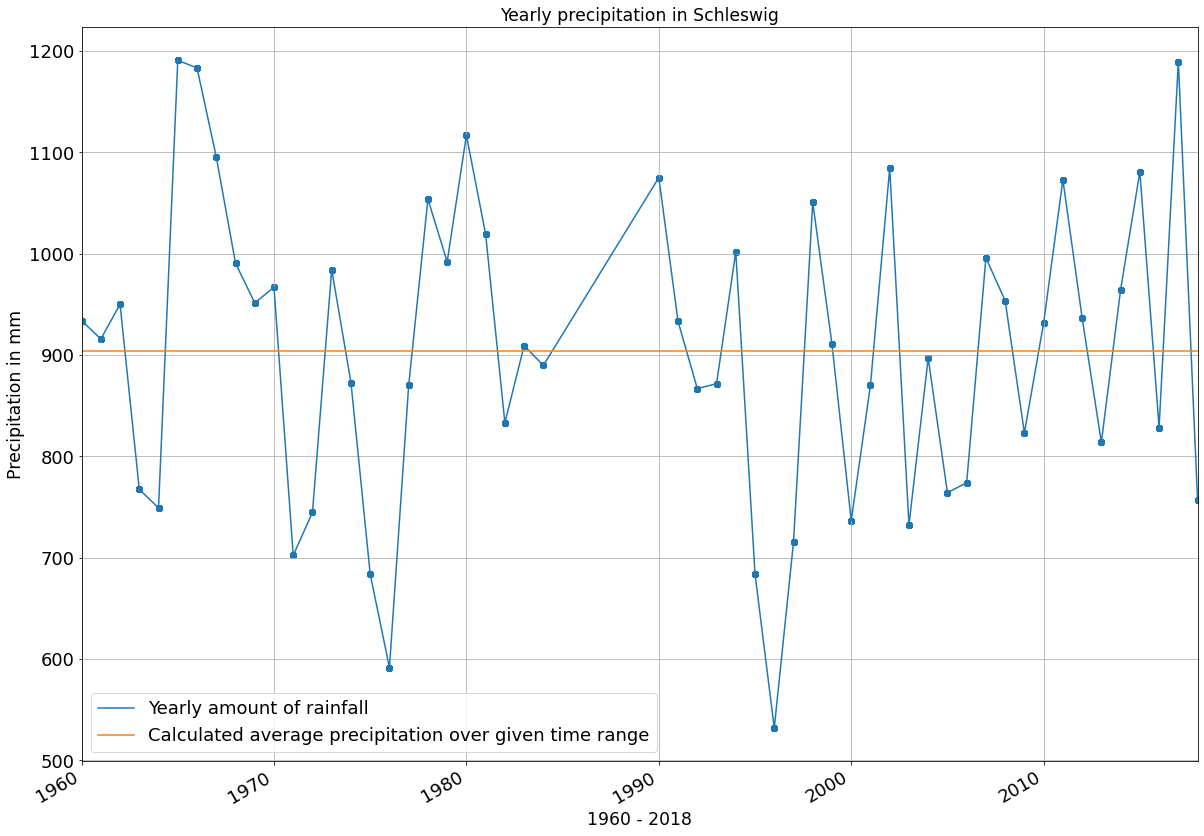

In [18]:
df = pd.read_csv(indatapath, header=0, sep=';',usecols=[1,14])
df['start_dt'] = pd.to_datetime(df.MESS_DATUM_BEGINN, format='%Y%m%d')
df['year'] = df['start_dt'].dt.year
df.sort_values(by=['year'], ascending=[True], inplace=True, axis=0)
df.rename(columns={"MO_RR": "rain"}, inplace=True) # rain includes all kind of precipitation
df = df.loc[(df.start_dt >= pd.to_datetime('19600101', format='%Y%m%d'))] # from year 1960
df = df.loc[(df.rain >= 0)] # discard negative values

# check all months were reported:
#print(df.groupby(['year'], sort=False, as_index=False).year.count())
# Exclude incomplete years i.e. the ones with less than 12 obs:
g = df.groupby('year', sort=False)
valid = pd.DataFrame(g['rain'].count())
valid.rename(columns={'rain':'months_with_measures'}, inplace=True)
valid = valid.loc[(valid['months_with_measures'] == 12)]
valid['year_'] = valid.index
df = df.merge(valid, left_on='year', right_on='year_', how='inner', sort=False)
#print(df.loc[df.year == 1985 ]) # 1985 should be discarded for incomplete measures
yearly = df.groupby('year')['rain'].sum() # returns Series object
df['yearly_mean'] = yearly.mean() # mean over all years
df = df.merge(yearly, left_on='year', right_on='year', how='outer')
df.rename(columns={'rain_y':'rain_sum'}, inplace=True)
print(df)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=[20,15])

ax.plot(yearly, label='Yearly amount of rainfall')
ax.scatter(df['year'], df.rain_sum)
ax.plot(df['year'], df['yearly_mean'], label='Calculated average precipitation over given time range')
ax.set_xlim(1960, 2018)
ax.tick_params(labelsize=18)

ax.set_title('Yearly precipitation in Schleswig', fontsize='xx-large')
ax.legend(loc=3, prop={'size': 18})
ax.grid(True)

plt.xlabel('1960 - 2018', fontsize='xx-large')
plt.ylabel('Precipitation in mm', fontsize='xx-large')
fig.autofmt_xdate(rotation=30)
